## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
import lightgbm as lgb
import xgboost as xgb
# import timeb
from collections import Counter
import datetime
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
import eli5
import shap
from IPython.display import HTML
import json
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from sklearn import metrics
from typing import Any
from itertools import product
import re
from tqdm import tqdm
from joblib import Parallel, delayed

random_seed = 33

Using TensorFlow backend.


In [2]:
# train = pd.read_csv('../data/preprocess/train895.csv')
# test = pd.read_csv('../data/preprocess/test895.csv')
# # train = pd.read_csv('../data/preprocess/train_1225.csv')
# # test = pd.read_csv('../data/preprocess/test_1225.csv')
# train = pd.read_csv('../data/preprocess/train_1225_2.csv')
# test = pd.read_csv('../data/preprocess/test_1225_2.csv')

# train = pd.read_csv('../data/preprocess/train_0102_filter.csv')
# test = pd.read_csv('../data/preprocess/test_0102_filter.csv')
# train = pd.read_csv('../data/preprocess/train_0102_filter_reset3.csv')
# test = pd.read_csv('../data/preprocess/test_0102_filter_reset3.csv')


train = pd.read_csv('../data/preprocess/train_0106.csv')
test = pd.read_csv('../data/preprocess/test_0106.csv')

In [3]:
train

,installation_id,game_session,title,world,timestamp,timestamp_weekday,timestamp_daytime,last_session_timestamp_diff,acmu_type_Clip,acmu_type_Activity,...,time_diff_hour_session1,time_diff_hour_session2,time_diff_hour_session3,time_diff_hour_session4,time_diff_hour_session5,session_cnt_10min,session_cnt_30min,session_cnt_1hour,session_cnt_1day,session_cnt_7day
0,0006a69f,901acc108f55a5a1,32,2,2019-08-06 05:22:01.344000+00:00,1,322,0,10,3,...,-1440.0,-1440.0,-1440.0,-1440.0,-1440.0,1.0,1.0,1.0,1.0,1.0
1,0006a69f,77b8ee947eb84b4e,28,2,2019-08-06 05:35:19.167000+00:00,1,335,1,13,4,...,13.0,-1440.0,-1440.0,-1440.0,-1440.0,1.0,2.0,2.0,2.0,2.0
2,0006a69f,6bdf9623adc94d89,32,2,2019-08-06 05:37:50.020000+00:00,1,337,2,13,4,...,2.0,15.0,-1440.0,-1440.0,-1440.0,2.0,3.0,3.0,3.0,3.0
3,0006a69f,9501794defd84e4d,32,2,2019-08-06 20:34:53.812000+00:00,1,1234,0,23,9,...,897.0,899.0,912.0,-1440.0,-1440.0,1.0,1.0,1.0,4.0,4.0
4,0006a69f,a9ef3ecb3d1acc6a,28,2,2019-08-06 20:49:59.095000+00:00,1,1249,1,26,10,...,15.0,912.0,914.0,927.0,-1440.0,1.0,2.0,2.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17685,ffc90c32,460e8bdc2822b340,29,3,2019-07-30 12:12:49.516000+00:00,1,732,633,20,7,...,639.0,652.0,889.0,897.0,898.0,1.0,1.0,1.0,6.0,6.0
17686,ffd2871d,b05a02b52d5c1f4c,4,1,2019-08-07 01:06:38.407000+00:00,2,66,3,3,2,...,-1440.0,-1440.0,-1440.0,-1440.0,-1440.0,1.0,1.0,1.0,1.0,1.0
17687,ffeb0b1b,dadd1a4d8ac68ab0,4,1,2019-09-09 15:34:41.704000+00:00,0,934,1,7,3,...,-1440.0,-1440.0,-1440.0,-1440.0,-1440.0,1.0,1.0,1.0,1.0,1.0
17688,ffeb0b1b,a6885ab824fbc32c,32,2,2019-09-22 01:58:20.095000+00:00,6,118,2,12,3,...,17903.0,-1440.0,-1440.0,-1440.0,-1440.0,1.0,1.0,1.0,1.0,1.0


## Helper function

In [4]:
def cut_pred(pr1: np.array, coef: list):
    assert len(coef)==3
    pr1[pr1 <= coef[0]] = 0
    pr1[np.where(np.logical_and(pr1 > coef[0], pr1 <= coef[1]))] = 1
    pr1[np.where(np.logical_and(pr1 > coef[1], pr1 <= coef[2]))] = 2
    pr1[pr1 > coef[2]] = 3
    
    return pr1

## custom eval_metrics

In [5]:
from sklearn.metrics import cohen_kappa_score

## https://github.com/catboost/tutorials/blob/master/custom_loss/custom_loss_and_metric_tutorial.ipynb
class qwk(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is list of indexed containers
        # (containers with only __len__ and __getitem__ defined), one container
        # per approx dimension. Each container contains floats.
        # weight is one dimensional indexed container.
        # target is float.   
        # weight parameter can be None.
        # Returns pair (error, weights sum)

        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 1.0
        y_true = []
        y_pred = []
        for i in range(len(approx)):
            y_true.append(target[i])
            y_pred.append(approx[i])
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        
        y_pred[y_pred <= 1.12232214] = 0
        y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
        y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
        y_pred[y_pred > 2.22506454] = 3
        
        error_sum = cohen_kappa_score(y_true, y_pred,weights='quadratic')
#         error_sum = qwk(y_true, y_pred)
        
        return error_sum, weight_sum

@jit
def qwk_np(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred2 = y_pred.copy()
    y_pred2[y_pred2 <= 1.12232214] = 0
    y_pred2[np.where(np.logical_and(y_pred2 > 1.12232214, y_pred2 <= 1.73925866))] = 1
    y_pred2[np.where(np.logical_and(y_pred2 > 1.73925866, y_pred2 <= 2.22506454))] = 2
    y_pred2[y_pred2 > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'qwk', qwk_np(y_true, y_pred2), True

def eval_qwk_lgb_regr2(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred2 = y_pred.copy()
    y_pred2[y_pred2 <= 0.5] = 0
    y_pred2[np.where(np.logical_and(y_pred2 > 0.5, y_pred2 <= 1.5))] = 1
    y_pred2[np.where(np.logical_and(y_pred2 > 1.5, y_pred2 <= 2.5))] = 2
    y_pred2[y_pred2 > 2.5] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'qwk2', qwk_np(y_true, y_pred2), True

In [6]:
def find_col(df, cols):
    ## return the index of cols in df.columns, ignore if col not exit
    cols2 = []
    for c in cols:
        if c in df.columns:
            cols2.append(c)
    return cols2

In [7]:
import eli5
from eli5.sklearn import PermutationImportance

## Wrapper
class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None, permutation=False):
        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
            del params['cat_cols']
        else:
            categorical_columns = 'auto'
        
#         eval_metric = lambda y_true, y_pred: [eval_qwk_lgb_regr(y_true, y_pred), eval_qwk_lgb_regr2(y_true, y_pred)]
        eval_metric = eval_qwk_lgb_regr

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_
        
        if permutation:
#             perm = PermutationImportance(self.model, random_state=self.random_seed).fit(X_valid, y_valid)
            perm = PermutationImportance(self.model).fit(X_valid, y_valid)
            self.feature_importances2_ = pd.DataFrame({'feature':X_valid.columns.tolist(),'importance':perm.feature_importances_})

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)


class CatboostWrapper_regr(object):
    """
    A wrapper for catboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = CatBoostRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None, permutation=False):
        
        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
            del params['cat_cols']
        else:
            categorical_columns = None

        eval_set = []
        eval_names = []
        self.model = self.model.set_params(**params)
        self.model = self.model.set_params(eval_metric=qwk())
        
        
        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')
        elif X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')
        else:
            eval_set.append((X_train, y_train))
            eval_names.append('train')

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       cat_features=categorical_columns)

        self.best_score_ = self.model.get_best_score()
        
        test_pool=Pool(X_valid, y_valid,cat_features=categorical_columns)
        self.feature_importances_ = self.model.get_feature_importance(test_pool,thread_count=4)

    def predict(self, X_test):
        return self.model.predict(X_test, ntree_end=self.model.get_best_iteration())


from sklearn.base import BaseEstimator, TransformerMixin
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):
#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [8]:
class RegressorModel(object):
    """
    A wrapper class for regression models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).
    """

    def __init__(self, columns: list=None, model_wrapper=None, random_state=33):
        """
        :param columns: columns to train
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.random_seed = random_state
        
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            X_append: pd.DataFrame = None, y_append: pd.DataFrame = None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True,
            permutation=False):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=self.random_seed)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        ## model FI and permutation FI
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.feature_importances_p = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]
        if X_append is not None:
            X_append = X_append[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
                
#             print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = pd.concat([X.iloc[train_index],X_append],axis=0), X.iloc[valid_index]
            y_train, y_valid = pd.concat([y.iloc[train_index],y_append],axis=0), y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

#             if adversarial:
#                 X_new1 = X_train.copy()
#                 if X_valid is not None:
#                     X_new2 = X_valid.copy()
#                 elif X_holdout is not None:
#                     X_new2 = X_holdout.copy()
#                 X_new = pd.concat([X_new1, X_new2], axis=0)
#                 y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
#                 X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params.copy(), permutation=permutation)
            self.folds_dict[fold_n]['scores'] = model.best_score_
            
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            if permutation:
                fold_importance_p = pd.DataFrame(list(zip(X_train.columns, model.feature_importances2_)),
                                               columns=['feature', 'importance'])
                self.feature_importances_p = self.feature_importances.append(fold_importance_p)
            
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(float)
        if permutation:
            self.feature_importances_p['importance'] = self.feature_importances_p['importance'].astype(float)

        self.calc_scores_()
        
        if plot:
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')
        print(feature_importances.sort_values(by='importance'))

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10, fi_type=1):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        fi = self.feature_importances
        if fi_type=='p':
            fi = self.feature_importances_p
            
        grouped_feats = fi.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def get_top_features2(self, drop_null_importance: bool = True, top_n: int = 10, fi_type=1):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        fi = self.feature_importances
        if fi_type=='p':
            fi = self.feature_importances_p
            
        grouped_feats = fi.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return grouped_feats.sort_values(ascending=False).iloc[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')


In [9]:
lgb_params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 50,
            'early_stopping_rounds': 100, 
#             'eval_metric': lgb_kappa_eval,
#             'eval_metric': ['qwk','qwk2','qwk3']
            }

cat_params = {'iterations':2000,
            'loss_function': 'RMSE',
            'verbose': 50,
            'early_stopping_rounds': 100, 
#             'task_type':"GPU",
#             'devices':'0:1',
            }

para_tune = {'feature_fraction': 0.9985706623844444, 'lambda_l1': 1.3464702887971034, 'lambda_l2': 24.03486401669668, 'max_depth': 9, 'num_leaves': 20, 'subsample': 0.9982720526777418, 'subsample_freq': 2}
## 0.970
# para_tune = {'feature_fraction': 0.7208784814394442, 'lambda_l1': 1.0547998031340668, 'lambda_l2': 47.046761174073815, 'max_depth': 15, 'num_leaves': 39, 'subsample': 0.9658561677957942, 'subsample_freq': 1}

# for k in para_tune:
#     lgb_params[k] = para_tune[k]

In [10]:
train = train.fillna(-10)

Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.954685	train's qwk: 0.643506	valid's rmse: 0.988192	valid's qwk: 0.611881
[100]	train's rmse: 0.896144	train's qwk: 0.685969	valid's rmse: 0.971054	valid's qwk: 0.618669
[150]	train's rmse: 0.858594	train's qwk: 0.713832	valid's rmse: 0.969429	valid's qwk: 0.617254
[200]	train's rmse: 0.826988	train's qwk: 0.740146	valid's rmse: 0.96808	valid's qwk: 0.620344
Early stopping, best iteration is:
[105]	train's rmse: 0.891875	train's qwk: 0.687798	valid's rmse: 0.970532	valid's qwk: 0.621321
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.955483	train's qwk: 0.645237	valid's rmse: 0.99273	valid's qwk: 0.612847
[100]	train's rmse: 0.89773	train's qwk: 0.684395	valid's rmse: 0.972679	valid's qwk: 0.623464
[150]	train's rmse: 0.860932	train's qwk: 0.713392	valid's rmse: 0.968798	valid's qwk: 0.625087
[200]	train's rmse: 0.829959	train's qwk: 0.739828	valid's rmse: 0.967087	vali

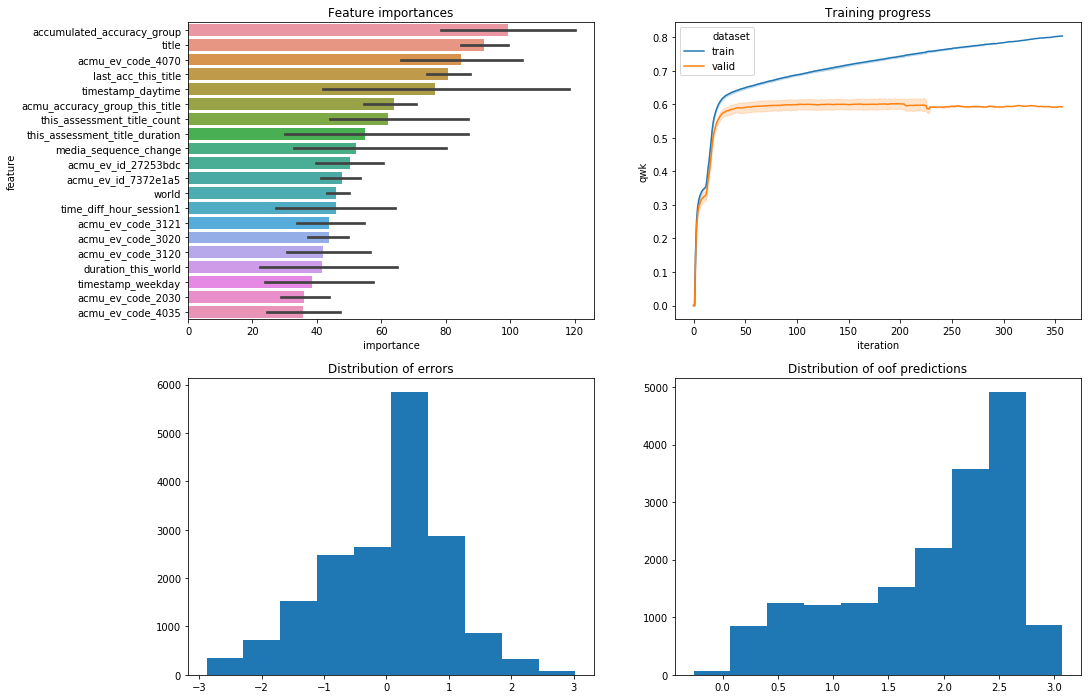

In [13]:
y = train['accuracy_group']
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

cat_cols = ['title','world','timestamp_weekday']
cols_to_drop = ['installation_id', 'game_session', 'timestamp', 'accuracy_group']
cat_params['cat_cols'] = cat_cols
lgb_params['cat_cols'] = cat_cols


mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=train, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)
# regressor_model1 = RegressorModel(model_wrapper=CatboostWrapper_regr())
# regressor_model1.fit(X=train, y=y, folds=folds, params=cat_params, preprocesser=mt, transformers=transformers,
#                     eval_metric='qwk', cols_to_drop=cols_to_drop)

## Feature Selection
https://blog.csdn.net/LY_ysys629/article/details/53641569
https://scikit-learn.org/stable/modules/feature_selection.html

1. Removing features with low variance
2. Pearson Correlation
    f_regression
3. Mutual information and maximal information coefficient (MIC)
    mutual_info_regression
4. Distance correlation

5. Lasso
6. Ridge 
7. model based(lgb)


In [14]:
X = train.drop(columns=cols_to_drop)
col = X.columns[X.isnull().sum()>0]
X = X.drop(columns=col)

from sklearn.preprocessing import StandardScaler
X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)

X_default = train.loc[:,['installation_id','timestamp','timestamp_weekday','timestamp_daytime','game_session','world','title','type']]
lgb_params['verbose']=0

In [15]:
from sklearn.feature_selection import SelectKBest, f_regression

for i in range(50,900,50):
    K_select = SelectKBest(f_regression, k=i).fit(X, y)
    X_new = X.iloc[:,K_select.get_support()]
    print('\n',i)
    X_new = pd.concat([X_new,X_default],axis=1)
    regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
    regressor_model.fit(X=X_new, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False,plot=False)



 50

CV mean score on train: 0.6279 +/- 0.0071 std.
CV mean score on valid: 0.5736 +/- 0.0134 std.

 100

CV mean score on train: 0.6512 +/- 0.0073 std.
CV mean score on valid: 0.5745 +/- 0.0177 std.

 150

CV mean score on train: 0.6711 +/- 0.0137 std.
CV mean score on valid: 0.5884 +/- 0.0162 std.

 200

CV mean score on train: 0.6792 +/- 0.0052 std.
CV mean score on valid: 0.5876 +/- 0.0195 std.

 250

CV mean score on train: 0.6958 +/- 0.0277 std.
CV mean score on valid: 0.5908 +/- 0.0190 std.

 300

CV mean score on train: 0.6890 +/- 0.0282 std.
CV mean score on valid: 0.5905 +/- 0.0193 std.

 350

CV mean score on train: 0.6972 +/- 0.0341 std.
CV mean score on valid: 0.5952 +/- 0.0201 std.

 400

CV mean score on train: 0.7011 +/- 0.0174 std.
CV mean score on valid: 0.5962 +/- 0.0187 std.

 450

CV mean score on train: 0.7062 +/- 0.0189 std.
CV mean score on valid: 0.5971 +/- 0.0191 std.

 500

CV mean score on train: 0.7050 +/- 0.0224 std.
CV mean score on valid: 0.5986 +/- 0.0

In [16]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

for i in range(50,900,50):
    K_select = SelectKBest(mutual_info_regression, k=i).fit(X, y)
    X_new = X.iloc[:,K_select.get_support()]
    print(i)
    X_new = pd.concat([X_new,X_default],axis=1)
    regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
    regressor_model.fit(X=X_new, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False,plot=False)


50

CV mean score on train: 0.6753 +/- 0.0076 std.
CV mean score on valid: 0.5824 +/- 0.0153 std.
100

CV mean score on train: 0.6877 +/- 0.0121 std.
CV mean score on valid: 0.5928 +/- 0.0182 std.
150

CV mean score on train: 0.7027 +/- 0.0381 std.
CV mean score on valid: 0.5954 +/- 0.0223 std.
200

CV mean score on train: 0.6989 +/- 0.0235 std.
CV mean score on valid: 0.6008 +/- 0.0199 std.
250

CV mean score on train: 0.7159 +/- 0.0292 std.
CV mean score on valid: 0.5980 +/- 0.0179 std.
300

CV mean score on train: 0.7074 +/- 0.0090 std.
CV mean score on valid: 0.5982 +/- 0.0195 std.
350

CV mean score on train: 0.6980 +/- 0.0234 std.
CV mean score on valid: 0.5999 +/- 0.0202 std.
400

CV mean score on train: 0.7274 +/- 0.0119 std.
CV mean score on valid: 0.6033 +/- 0.0173 std.
450

CV mean score on train: 0.7147 +/- 0.0258 std.
CV mean score on valid: 0.6010 +/- 0.0189 std.
500

CV mean score on train: 0.7213 +/- 0.0189 std.
CV mean score on valid: 0.6026 +/- 0.0178 std.
550

CV mea

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif

for i in range(50,900,50):
    K_select = SelectKBest(f_classif, k=i).fit(X, y)
    X_new = X.iloc[:,K_select.get_support()]
    print(i)
    X_new = pd.concat([X_new,X_default],axis=1)
    regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
    regressor_model.fit(X=X_new, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False,plot=False)


50

CV mean score on train: 0.6307 +/- 0.0065 std.
CV mean score on valid: 0.5738 +/- 0.0160 std.
100

CV mean score on train: 0.6542 +/- 0.0071 std.
CV mean score on valid: 0.5770 +/- 0.0187 std.
150

CV mean score on train: 0.6626 +/- 0.0160 std.
CV mean score on valid: 0.5862 +/- 0.0171 std.
200

CV mean score on train: 0.6811 +/- 0.0147 std.
CV mean score on valid: 0.5887 +/- 0.0179 std.
250

CV mean score on train: 0.6749 +/- 0.0056 std.
CV mean score on valid: 0.5900 +/- 0.0221 std.
300

CV mean score on train: 0.7009 +/- 0.0200 std.
CV mean score on valid: 0.5925 +/- 0.0210 std.
350

CV mean score on train: 0.7009 +/- 0.0250 std.
CV mean score on valid: 0.5966 +/- 0.0212 std.
400

CV mean score on train: 0.7050 +/- 0.0102 std.
CV mean score on valid: 0.5955 +/- 0.0207 std.
450

CV mean score on train: 0.6994 +/- 0.0237 std.
CV mean score on valid: 0.5968 +/- 0.0186 std.
500

CV mean score on train: 0.7124 +/- 0.0092 std.
CV mean score on valid: 0.5978 +/- 0.0178 std.
550

CV mea

In [18]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

clf = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)

for i in range(50,900,50):
    print(i)
    model = SelectFromModel(clf, prefit=True, max_features=i, threshold=-np.inf)
    X_new = X.iloc[:,model.get_support()]
    X_new = pd.concat([X_new,X_default],axis=1)
    
    regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
    regressor_model.fit(X=X_new, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False,plot=False)

50

CV mean score on train: 0.6557 +/- 0.0170 std.
CV mean score on valid: 0.5897 +/- 0.0190 std.
100

CV mean score on train: 0.6825 +/- 0.0157 std.
CV mean score on valid: 0.5956 +/- 0.0214 std.
150

CV mean score on train: 0.6936 +/- 0.0069 std.
CV mean score on valid: 0.5997 +/- 0.0208 std.
200

CV mean score on train: 0.7046 +/- 0.0083 std.
CV mean score on valid: 0.6007 +/- 0.0189 std.
250

CV mean score on train: 0.7094 +/- 0.0214 std.
CV mean score on valid: 0.6008 +/- 0.0200 std.
300

CV mean score on train: 0.7138 +/- 0.0301 std.
CV mean score on valid: 0.6019 +/- 0.0184 std.
350

CV mean score on train: 0.7137 +/- 0.0092 std.
CV mean score on valid: 0.6002 +/- 0.0208 std.
400

CV mean score on train: 0.7095 +/- 0.0217 std.
CV mean score on valid: 0.6006 +/- 0.0212 std.
450

CV mean score on train: 0.6909 +/- 0.0270 std.
CV mean score on valid: 0.5994 +/- 0.0207 std.
500

CV mean score on train: 0.7064 +/- 0.0096 std.
CV mean score on valid: 0.6020 +/- 0.0174 std.
550

CV mea

In [19]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

clf = Lasso(alpha=.3).fit(X, y)

for i in range(50,900,50):
    print(i)
    model = SelectFromModel(clf, prefit=True, max_features=i, threshold=-np.inf)
    X_new = X.iloc[:,model.get_support()]
    X_new = pd.concat([X_new,X_default],axis=1)
    
    regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
    regressor_model.fit(X=X_new, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False,plot=False)

50

CV mean score on train: 0.6867 +/- 0.0165 std.
CV mean score on valid: 0.5528 +/- 0.0171 std.
100

CV mean score on train: 0.6776 +/- 0.0172 std.
CV mean score on valid: 0.5722 +/- 0.0150 std.
150

CV mean score on train: 0.7151 +/- 0.0174 std.
CV mean score on valid: 0.5818 +/- 0.0169 std.
200

CV mean score on train: 0.7331 +/- 0.0166 std.
CV mean score on valid: 0.5846 +/- 0.0180 std.
250

CV mean score on train: 0.7134 +/- 0.0179 std.
CV mean score on valid: 0.5834 +/- 0.0163 std.
300

CV mean score on train: 0.7090 +/- 0.0251 std.
CV mean score on valid: 0.5875 +/- 0.0162 std.
350

CV mean score on train: 0.6930 +/- 0.0136 std.
CV mean score on valid: 0.5886 +/- 0.0153 std.
400

CV mean score on train: 0.7322 +/- 0.0151 std.
CV mean score on valid: 0.5869 +/- 0.0144 std.
450

CV mean score on train: 0.7046 +/- 0.0156 std.
CV mean score on valid: 0.5862 +/- 0.0159 std.
500

CV mean score on train: 0.7208 +/- 0.0319 std.
CV mean score on valid: 0.5872 +/- 0.0184 std.
550

CV mea

In [20]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge

clf = Ridge(alpha=1.0).fit(X, y)

for i in range(50,900,50):
    print(i)
    model = SelectFromModel(clf, prefit=True, max_features=i, threshold=-np.inf)
    X_new = X.iloc[:,model.get_support()]
    X_new = pd.concat([X_new,X_default],axis=1)
    
    regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
    regressor_model.fit(X=X_new, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False,plot=False)

50

CV mean score on train: 0.6564 +/- 0.0169 std.
CV mean score on valid: 0.5319 +/- 0.0191 std.
100

CV mean score on train: 0.6731 +/- 0.0168 std.
CV mean score on valid: 0.5369 +/- 0.0147 std.
150

CV mean score on train: 0.6913 +/- 0.0190 std.
CV mean score on valid: 0.5799 +/- 0.0166 std.
200

CV mean score on train: 0.6818 +/- 0.0140 std.
CV mean score on valid: 0.5834 +/- 0.0164 std.
250

CV mean score on train: 0.6982 +/- 0.0176 std.
CV mean score on valid: 0.5831 +/- 0.0186 std.
300

CV mean score on train: 0.6999 +/- 0.0207 std.
CV mean score on valid: 0.5970 +/- 0.0177 std.
350

CV mean score on train: 0.6831 +/- 0.0140 std.
CV mean score on valid: 0.5952 +/- 0.0171 std.
400

CV mean score on train: 0.6985 +/- 0.0178 std.
CV mean score on valid: 0.5945 +/- 0.0164 std.
450

CV mean score on train: 0.6759 +/- 0.0166 std.
CV mean score on valid: 0.5944 +/- 0.0190 std.
500

CV mean score on train: 0.7132 +/- 0.0061 std.
CV mean score on valid: 0.5957 +/- 0.0186 std.
550

CV mea

In [21]:
## base on lgb

for i in range(50,900,50):
    print(i)
    select_col = regressor_model1.get_top_features(top_n=i,fi_type='n')
    
    regressor_model = RegressorModel(columns=select_col+['installation_id'],model_wrapper=LGBWrapper_regr())
    regressor_model.fit(X=train, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False,plot=False)

50

CV mean score on train: 0.6864 +/- 0.0073 std.
CV mean score on valid: 0.5988 +/- 0.0209 std.
100

CV mean score on train: 0.7139 +/- 0.0095 std.
CV mean score on valid: 0.6020 +/- 0.0188 std.
150

CV mean score on train: 0.6971 +/- 0.0154 std.
CV mean score on valid: 0.6032 +/- 0.0185 std.
200

CV mean score on train: 0.7287 +/- 0.0216 std.
CV mean score on valid: 0.6048 +/- 0.0182 std.
250

CV mean score on train: 0.7063 +/- 0.0105 std.
CV mean score on valid: 0.6022 +/- 0.0206 std.
300

CV mean score on train: 0.7287 +/- 0.0233 std.
CV mean score on valid: 0.6048 +/- 0.0188 std.
350

CV mean score on train: 0.7043 +/- 0.0224 std.
CV mean score on valid: 0.6029 +/- 0.0195 std.
400

CV mean score on train: 0.7229 +/- 0.0188 std.
CV mean score on valid: 0.6028 +/- 0.0202 std.
450

CV mean score on train: 0.7246 +/- 0.0172 std.
CV mean score on valid: 0.6025 +/- 0.0196 std.
500

CV mean score on train: 0.7032 +/- 0.0065 std.
CV mean score on valid: 0.6009 +/- 0.0208 std.
550

CV mea

In [28]:
## RFE
## https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
from sklearn.feature_selection import RFE

lgb_params_rfe = {'n_estimators':120,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 0,
            }

for i in range(50,900,50):
    print(i)
    estimator = lgb.LGBMRegressor().set_params(**lgb_params_rfe)
    selector = RFE(estimator, n_features_to_select=i, step=0.02)
    selector = selector.fit(X, y)
    X_new = X.iloc[:,selector.get_support()]
    X_new = pd.concat([X_new,X_default],axis=1)
    
    regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
    regressor_model.fit(X=X_new, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False,plot=False)

50

CV mean score on train: 0.6957 +/- 0.0126 std.
CV mean score on valid: 0.6014 +/- 0.0167 std.
100

CV mean score on train: 0.7035 +/- 0.0256 std.
CV mean score on valid: 0.6043 +/- 0.0191 std.
150

CV mean score on train: 0.7267 +/- 0.0175 std.
CV mean score on valid: 0.6042 +/- 0.0201 std.
200

CV mean score on train: 0.7337 +/- 0.0301 std.
CV mean score on valid: 0.6031 +/- 0.0214 std.
250

CV mean score on train: 0.7321 +/- 0.0158 std.
CV mean score on valid: 0.6037 +/- 0.0205 std.
300

CV mean score on train: 0.7215 +/- 0.0148 std.
CV mean score on valid: 0.6030 +/- 0.0212 std.
350

CV mean score on train: 0.7305 +/- 0.0232 std.
CV mean score on valid: 0.6031 +/- 0.0197 std.
400

CV mean score on train: 0.7206 +/- 0.0262 std.
CV mean score on valid: 0.6027 +/- 0.0216 std.
450

CV mean score on train: 0.7475 +/- 0.0284 std.
CV mean score on valid: 0.6061 +/- 0.0187 std.
500

CV mean score on train: 0.7178 +/- 0.0271 std.
CV mean score on valid: 0.6040 +/- 0.0206 std.
550

CV mea


CV mean score on train: 0.7287 +/- 0.0216 std.
CV mean score on valid: 0.6048 +/- 0.0182 std.
                       feature  importance
21    assessment_duration_mean        12.0
19           acmu_ev_code_4035        12.0
17           timestamp_weekday        17.0
18           acmu_ev_code_2030        26.0
20        accumulated_accuracy        29.0
..                         ...         ...
4            timestamp_daytime       127.0
0   accumulated_accuracy_group       127.0
8        media_sequence_change       128.0
4            timestamp_daytime       136.0
0   accumulated_accuracy_group       140.0

[100 rows x 2 columns]


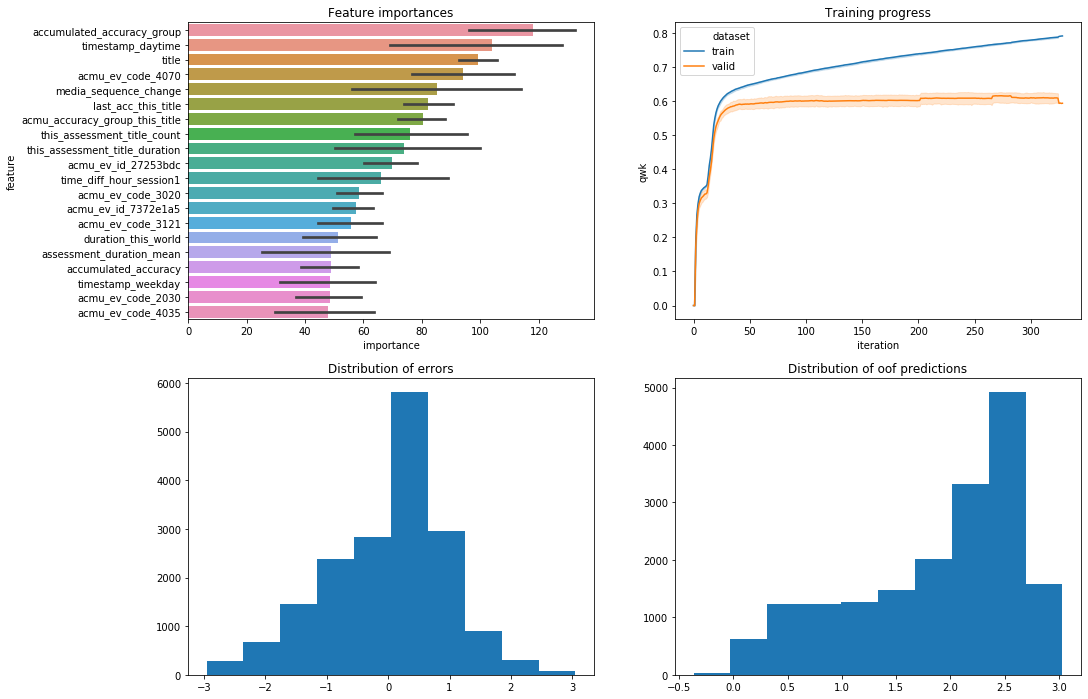

In [23]:
## feature selection
## permutation = True or False
select_col = regressor_model1.get_top_features(top_n=200,fi_type='n')

regressor_model2 = RegressorModel(columns=select_col+['installation_id'],model_wrapper=LGBWrapper_regr())
regressor_model2.fit(X=train, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)

In [24]:
select_col.sort()
select_col

['accumulated_accuracy',
 'accumulated_accuracy_group',
 'accumulated_incorrect_attempts',
 'acmu_acc_gp_0',
 'acmu_accuracy_attempt_Bird Measurer (Assessment)',
 'acmu_accuracy_attempt_Cart Balancer (Assessment)',
 'acmu_accuracy_attempt_Cauldron Filler (Assessment)',
 'acmu_accuracy_attempt_Chest Sorter (Assessment)',
 'acmu_accuracy_attempt_Mushroom Sorter (Assessment)',
 'acmu_accuracy_group_this_title',
 'acmu_ev_code_2000',
 'acmu_ev_code_2010',
 'acmu_ev_code_2020',
 'acmu_ev_code_2025',
 'acmu_ev_code_2030',
 'acmu_ev_code_2080',
 'acmu_ev_code_3010',
 'acmu_ev_code_3020',
 'acmu_ev_code_3021',
 'acmu_ev_code_3110',
 'acmu_ev_code_3120',
 'acmu_ev_code_3121',
 'acmu_ev_code_4010',
 'acmu_ev_code_4020',
 'acmu_ev_code_4021',
 'acmu_ev_code_4022',
 'acmu_ev_code_4025',
 'acmu_ev_code_4030',
 'acmu_ev_code_4031',
 'acmu_ev_code_4035',
 'acmu_ev_code_4040',
 'acmu_ev_code_4070',
 'acmu_ev_code_4090',
 'acmu_ev_code_4100',
 'acmu_ev_code_4220',
 'acmu_ev_code_4230',
 'acmu_ev_id_02a42007',
 'acmu_ev_id_04df9b66',
 'acmu_ev_id_0db6d71d',
 'acmu_ev_id_1325467d',
 'acmu_ev_id_15a43e5b',
 'acmu_ev_id_1af8be29',
 'acmu_ev_id_1c178d24',
 'acmu_ev_id_27253bdc',
 'acmu_ev_id_2dc29e21',
 'acmu_ev_id_363c86c9',
 'acmu_ev_id_37db1c2f',
 'acmu_ev_id_37ee8496',
 'acmu_ev_id_3afde5dd',
 'acmu_ev_id_3bf1cf26',
 'acmu_ev_id_3ee399c3',
 'acmu_ev_id_461eace6',
 'acmu_ev_id_499edb7c',
 'acmu_ev_id_4bb2f698',
 'acmu_ev_id_51102b85',
 'acmu_ev_id_5154fc30',
 'acmu_ev_id_5348fd84',
 'acmu_ev_id_562cec5f',
 'acmu_ev_id_565a3990',
 'acmu_ev_id_56817e2b',
 'acmu_ev_id_56cd3b43',
 'acmu_ev_id_587b5989',
 'acmu_ev_id_5c2f29ca',
 'acmu_ev_id_5e109ec3',
 'acmu_ev_id_5e812b27',
 'acmu_ev_id_69fdac0a',
 'acmu_ev_id_6bf9e3e1',
 'acmu_ev_id_6c517a88',
 'acmu_ev_id_7372e1a5',
 'acmu_ev_id_76babcde',
 'acmu_ev_id_792530f8',
 'acmu_ev_id_7da34a02',
 'acmu_ev_id_7dfe6d8a',
 'acmu_ev_id_84538528',
 'acmu_ev_id_884228c8',
 'acmu_ev_id_89aace00',
 'acmu_ev_id_8af75982',
 'acmu_ev_id_8b757ab8',
 'acmu_ev_id_8fee50e2',
 'acmu_ev_id_907a054b',
 'acmu_ev_id_91561152',
 'acmu_ev_id_9de5e594',
 'acmu_ev_id_9e34ea74',
 'acmu_ev_id_9ee1c98c',
 'acmu_ev_id_a0faea5d',
 'acmu_ev_id_a16a373e',
 'acmu_ev_id_a2df0760',
 'acmu_ev_id_a44b10dc',
 'acmu_ev_id_a7640a16',
 'acmu_ev_id_a8efe47b',
 'acmu_ev_id_ac92046e',
 'acmu_ev_id_acf5c23f',
 'acmu_ev_id_b012cd7f',
 'acmu_ev_id_b2dba42b',
 'acmu_ev_id_bb3e370b',
 'acmu_ev_id_bcceccc6',
 'acmu_ev_id_beb0a7b9',
 'acmu_ev_id_c277e121',
 'acmu_ev_id_c51d8688',
 'acmu_ev_id_c58186bf',
 'acmu_ev_id_c952eb01',
 'acmu_ev_id_ca11f653',
 'acmu_ev_id_cb6010f8',
 'acmu_ev_id_cf7638f3',
 'acmu_ev_id_cf82af56',
 'acmu_ev_id_d02b7a8e',
 'acmu_ev_id_d185d3ea',
 'acmu_ev_id_d3f1e122',
 'acmu_ev_id_d45ed6a1',
 'acmu_ev_id_e694a35b',
 'acmu_ev_id_f3cd5473',
 'acmu_ev_id_f50fc6c1',
 'acmu_ev_id_f5b8c21a',
 'acmu_ev_title_Crystal Caves - Level 2_2000',
 'acmu_incorrect_attempt_Cauldron Filler (Assessment)',
 'acmu_title_All Star Sorting',
 'acmu_title_Bottle Filler (Activity)',
 'acmu_title_Cart Balancer (Assessment)',
 'acmu_title_Cauldron Filler (Assessment)',
 'acmu_title_Chest Sorter (Assessment)',
 'acmu_title_Chow Time',
 'acmu_title_Crystal Caves - Level 3',
 'acmu_title_Dino Dive',
 'acmu_title_Fireworks (Activity)',
 'acmu_title_Leaf Leader',
 'acmu_title_Mushroom Sorter (Assessment)',
 'acmu_title_Sandcastle Builder (Activity)',
 'acmu_title_Scrub-A-Dub',
 'acmu_title_Tree Top City - Level 1',
 'acmu_title_Watering Hole (Activity)',
 'acmu_type_Clip',
 'acmu_world_CRYSTALCAVES',
 'acmu_world_MAGMAPEAK',
 'acmu_world_TREETOPCITY',
 'assessment_duration_mean',
 'duration_this_title',
 'duration_this_world',
 'duration_title_Air Show',
 'duration_title_All Star Sorting',
 'duration_title_Bird Measurer (Assessment)',
 'duration_title_Bottle Filler (Activity)',
 'duration_title_Bubble Bath',
 'duration_title_Bug Measurer (Activity)',
 'duration_title_Cart Balancer (Assessment)',
 'duration_title_Cauldron Filler (Assessment)',
 'duration_title_Ches


CV mean score on train: 0.7262 +/- 0.0140 std.
CV mean score on valid: 0.6008 +/- 0.0208 std.
                        feature  importance
30            acmu_ev_code_4020        18.0
983    assessment_duration_mean        22.0
48            acmu_ev_code_2030        23.0
996         duration_this_world        23.0
30            acmu_ev_code_4020        25.0
..                          ...         ...
3             timestamp_daytime        98.0
985  accumulated_accuracy_group        99.0
0                         title       111.0
46            acmu_ev_code_4070       112.0
985  accumulated_accuracy_group       127.0

[100 rows x 2 columns]


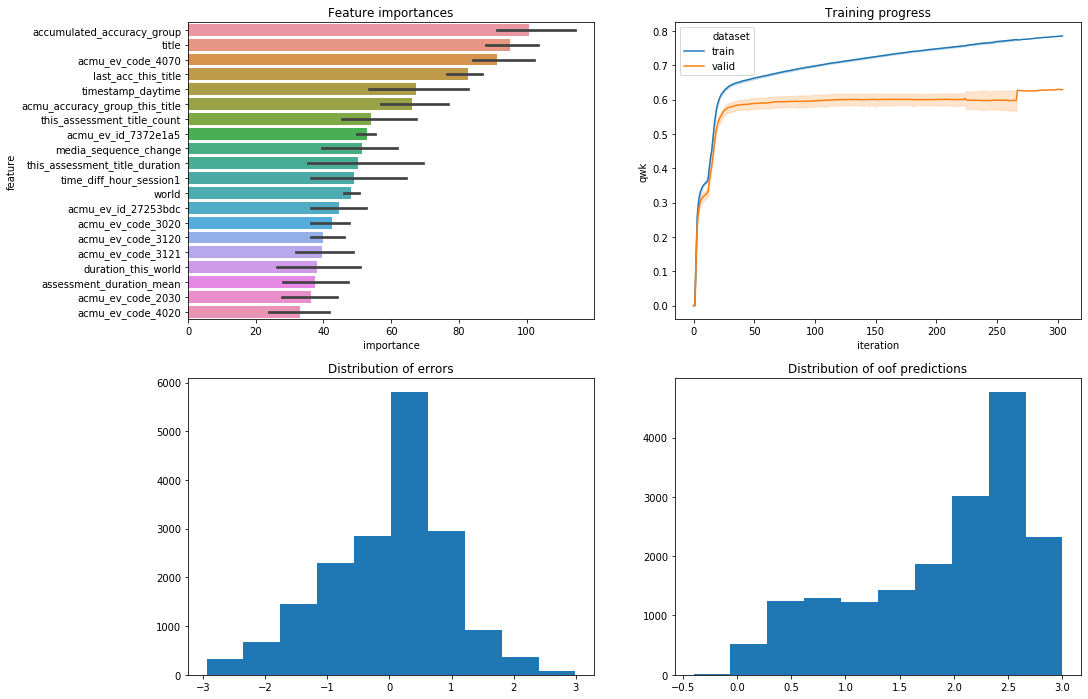

In [25]:
## semi-supervised learning
coef = [1.12232214,1.73925866,2.22506454]
y_test_pred = regressor_model2.predict(test)
y_test_pred = cut_pred(y_test_pred,coef)
X_append = test
y_append = pd.Series(y_test_pred.flatten())

# regressor_model3 = RegressorModel(columns=select_col+['installation_id'],model_wrapper=LGBWrapper_regr())
regressor_model3 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model3.fit(X=train, y=y, X_append=X_append, y_append=y_append, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)

In [26]:
## semi-supervised learning
## add train

# coef = [1.12232214,1.73925866,2.22506454]
# y_train_pseudo_pred = regressor_model2.predict(train_pseudo)
# y_train_pseudo_pred = cut_pred(y_train_pseudo_pred,coef)
# X_append = pd.concat([test,train_pseudo],axis=0)
# y_append = pd.concat([pd.Series(y_test_pred.flatten()),pd.Series(y_train_pseudo_pred.flatten())]).reset_index(drop=True)

# regressor_model4 = RegressorModel(columns=select_col+['installation_id'],model_wrapper=LGBWrapper_regr())
# regressor_model4.fit(X=train2, y=y2, X_append=X_append, y_append=y_append, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
#                     eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)

In [27]:
train.shape

(17690, 1012)